# Ruble Volatility Project — Part 2: Exploratory Data Analysis

This notebook continues the Ruble Volatility Project by exploring trends and patterns in the cleaned dataset prepared in Part 1.

In this notebook (`02_Exploratory_Data_Analysis.ipynb`), I will:

1. Visualize historical trends in the ruble exchange rate (RUB/USD)
2. Compare RUB movements to key macroeconomic indicators (GDP, FDI, inflation, oil prices)
3. Analyze volatility across time, including crisis years
4. Explore structural breaks, rolling statistics, and correlations
5. Prepare data for forecasting and causal inference in future notebooks

**The main modeling and forecasting work will be carried out in the next notebooks, starting with** `03_Time_Series_Modeling.ipynb`.

In [326]:
pip install holidays

python(36062) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


In [364]:
# Import the pandas_market_calendars module
# > Note: Some forecasting libraries are imported here in advance for use in Part 3 of the project.

%pip install pandas_market_calendars
import pandas_market_calendars as mcal
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error, mean_absolute_error


python(39016) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


### I. Loading data

Loading raw RUB exchange rate and macroeconomic data prepared in the previous notebook.

In [328]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_Ruble_Daily_Data2.csv", parse_dates=["date"])
data

,currency_rate,date,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation
0,125.2600,1992-07-01,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
1,134.8000,1992-07-03,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
2,130.5000,1992-07-08,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
3,130.3000,1992-07-10,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
4,130.2000,1992-07-15,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
...,...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,8,14260.000000,67.83,8.200000,3.300000e+09,8.140000
7666,80.3466,2025-08-19,2025,8,14260.000000,67.83,8.200000,3.300000e+09,8.140000
7667,80.1045,2025-08-20,2025,8,14260.000000,67.83,8.200000,3.300000e+09,8.140000
7668,80.2548,2025-08-21,2025,8,14260.000000,67.83,8.200000,3.300000e+09,8.140000


**Data Format Notes:**  
- `currency_rate`: RUB per 1 USD  
- `GDP_per_capita`: current US dollars  
- `Brent_price`: USD per barrel  
- `GDP_deflator` & `Inflation`: percentage (%)  
- `FD_investment`: **billions** of US dollars

### II. Data Quality Assessment

In [329]:
# double-checking for any NAs
print(data.isna().sum())

currency_rate     0
date              0
year              0
month             0
GDP_per_capita    0
Brent_price       0
GDP_deflator      0
FD_investment     0
Inflation         0
dtype: int64


Detect gaps or irregularities across all years

In [330]:
data = data.sort_values("date")
full_range = pd.date_range(start=data["date"].min(), end=data["date"].max(), freq="D")
missing_dates = full_range.difference(data["date"])
print(f"Missing dates: {len(missing_dates)}")
print(missing_dates)

Missing dates: 4436
DatetimeIndex(['1992-07-02', '1992-07-04', '1992-07-05', '1992-07-06',
               '1992-07-07', '1992-07-09', '1992-07-11', '1992-07-12',
               '1992-07-13', '1992-07-14',
               ...
               '2025-07-19', '2025-07-20', '2025-07-26', '2025-07-27',
               '2025-08-02', '2025-08-03', '2025-08-09', '2025-08-10',
               '2025-08-16', '2025-08-17'],
              dtype='datetime64[ns]', length=4436, freq=None)


In [331]:
try:
    import holidays
    ru_holidays = holidays.RU(years=range(1992, 2026))
    missing_df = pd.DataFrame({'date': missing_dates})
    missing_df["is_holiday"] = missing_df["date"].isin(ru_holidays)
except ImportError:
    print("holidays not installed; skipping holiday flag.")
    missing_df = pd.DataFrame({'date': missing_dates})
    missing_df["is_holiday"] = False

# add weekday number (0=Mon, 6=Sun)
missing_df["weekday"] = missing_df["date"].dt.weekday

# add weekend flag
missing_df["is_weekend"] = missing_df["weekday"] >= 5  # Saturday or Sunday

print(missing_df[["is_holiday", "is_weekend"]].value_counts())

is_holiday  is_weekend
False       False         2083
            True          1924
True        False          342
            True            87
Name: count, dtype: int64


In [332]:
missing_df[missing_df["date"].dt.year == 2025]

,date,is_holiday,weekday,is_weekend
4371,2025-01-01,True,2,False
4372,2025-01-02,True,3,False
4373,2025-01-04,True,5,True
4374,2025-01-05,True,6,True
4375,2025-01-07,True,1,False
...,...,...,...,...
4431,2025-08-03,False,6,True
4432,2025-08-09,False,5,True
4433,2025-08-10,False,6,True
4434,2025-08-16,False,5,True


In [333]:
counts = missing_df[["is_holiday", "is_weekend"]].value_counts()

count_weekday_only = counts.loc[(False, False)]
count_weekend_only = counts.loc[(False, True)]
count_holiday_only = counts.loc[(True, False)]
count_holiday_and_weekend = counts.loc[(True, True)]

print(f"{count_weekday_only} Missing dates that are regular weekdays and not holidays — these are unexplained gaps that could signal missing data or non-trading days.")
print(f"{count_weekend_only} Missing dates that fell on weekends but were not official holidays. Also considered normal missingness for daily financial data.")
print(f"{count_holiday_only} Missing dates that were official Russian holidays, but not weekends. These are justified gaps.")
print(f"{count_holiday_and_weekend} Missing dates that were both holidays and weekends. Double justification.")

2083 Missing dates that are regular weekdays and not holidays — these are unexplained gaps that could signal missing data or non-trading days.
1924 Missing dates that fell on weekends but were not official holidays. Also considered normal missingness for daily financial data.
342 Missing dates that were official Russian holidays, but not weekends. These are justified gaps.
87 Missing dates that were both holidays and weekends. Double justification.


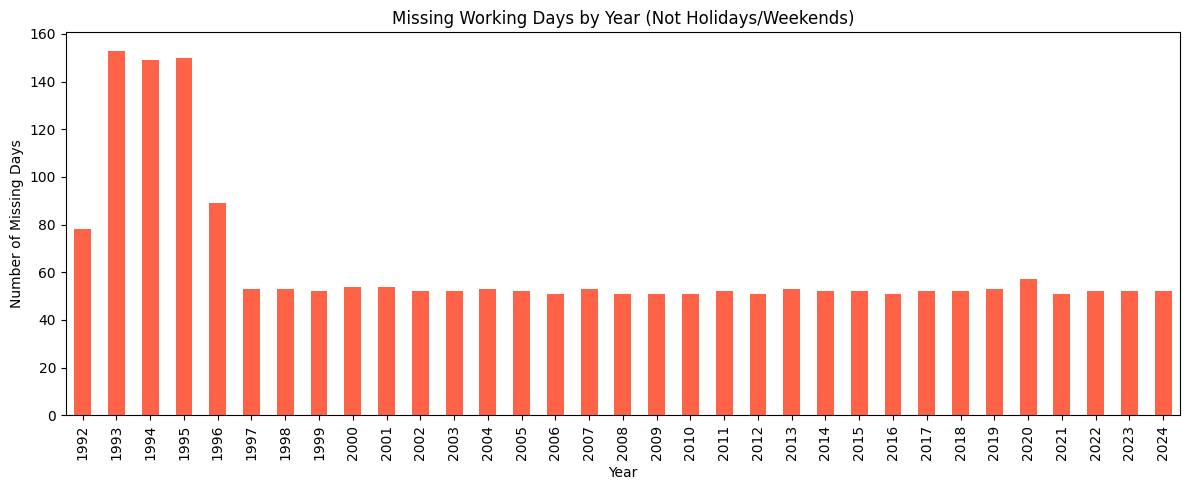

In [334]:
working_day_gaps['year'] = working_day_gaps['date'].dt.year
missing_by_year = working_day_gaps['year'].value_counts().sort_index()
missing_by_year.plot(kind='bar', figsize=(12, 5), color='tomato')
plt.title('Missing Working Days by Year (Not Holidays/Weekends)')
plt.xlabel('Year')
plt.ylabel('Number of Missing Days')
plt.tight_layout()
plt.show()

I examined 2,083 missing trading days that were **neither holidays nor weekends**. The analysis revealed:


- A large concentration of missing working days occurred between 1992–1996, likely due to post-Soviet disruptions in financial infrastructure.
- From 1997 onward, missing data stabilizes around ~55 days per year, suggesting more consistent data collection.
- A slight uptick around 2020–2021 may be linked to the COVID-19 pandemic.

These patterns suggest that early years (1992–1996) require caution due to potential data unreliability, possibly tied to political and institutional transitions. However, most years after 1997 show stable data, making them suitable for time series modeling, volatility analysis, and event studies.

A question is: **Can we continue working with this data?**

Yes, but we should be careful with the years 1992–1996, since there are a lot of missing days likely due to instability after the Soviet Union collapsed.
We can either exclude these years from modeling or add a flag to account for them. I will continue my analysis and apply the appropriate approach later in this notebook.

In [335]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7670 entries, 0 to 7669
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   currency_rate   7670 non-null   float64       
 1   date            7670 non-null   datetime64[ns]
 2   year            7670 non-null   int64         
 3   month           7670 non-null   int64         
 4   GDP_per_capita  7670 non-null   float64       
 5   Brent_price     7670 non-null   float64       
 6   GDP_deflator    7670 non-null   float64       
 7   FD_investment   7670 non-null   float64       
 8   Inflation       7670 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 599.2 KB


In [336]:
data.describe()

,currency_rate,date,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation
count,7670.000000,7670,7670.000000,7670.000000,7670.000000,7670.000000,7670.000000,7.670000e+03,7670.000000
mean,464.412233,2010-02-24 10:21:26.049543680,2009.638592,6.655541,8572.722279,58.639331,42.715935,1.975617e+10,42.714613
min,5.960000,1992-07-01 00:00:00,1992.000000,1.000000,1330.757202,9.910000,0.898246,-3.980094e+10,0.898246
25%,28.670200,2002-06-27 06:00:00,2002.000000,4.000000,2930.670166,27.560000,7.490071,2.847300e+09,7.490071
50%,32.795300,2010-03-11 12:00:00,2010.000000,7.000000,9277.713867,59.090000,14.191110,9.478810e+09,14.191110
75%,72.388225,2017-11-29 18:00:00,2017.000000,10.000000,12425.029297,80.370000,18.538967,3.759477e+10,18.538967
max,5960.000000,2025-08-22 00:00:00,2025.000000,12.000000,15941.448242,138.400000,1490.418425,7.478291e+10,1490.418425
std,1388.749361,NaN,9.026007,3.393557,4951.677498,31.977625,160.131182,2.496022e+10,160.131467



* `RUB/USD exchange rate (currency_rate)` spans from ~6 to 5,960 with a median around 33, a huge spread reflecting redenomination and multiple crises. Standard deviation (~1,389) confirms extreme volatility 

* `GDP per capita` rose from ~1,300 to ~15,900 USD, showing long‑term growth but with large variation (std ~4,950)

* `Brent oil price` ranges from ~$10 to ~$138 with a mean of ~$59, clearly capturing oil booms and crashes

* `Inflation and GDP deflator` show very high peaks (max ~1,490%) consistent with early‑1990s hyperinflation; large std devs indicate strong instability

* `FDI` fluctuates sharply between large outflows (–$39 B) and inflows (+$74 B), showing high volatility of capital movement

Takeaway: All core variables are highly variable and non‑stationary, which makes transformations (log, differencing) and careful time‑series modeling essential.

### II. Unique values for categorical features

As we can see above, the currency_rate column shows extreme variation. On January 1, 1998, the Russian government implemented a 1,000:1 currency redenomination, replacing old banknotes with new ones to simplify the monetary system after a period of high inflation.

This creates a structural break in the time series, which needs to be carefully handled for any analysis or modeling.

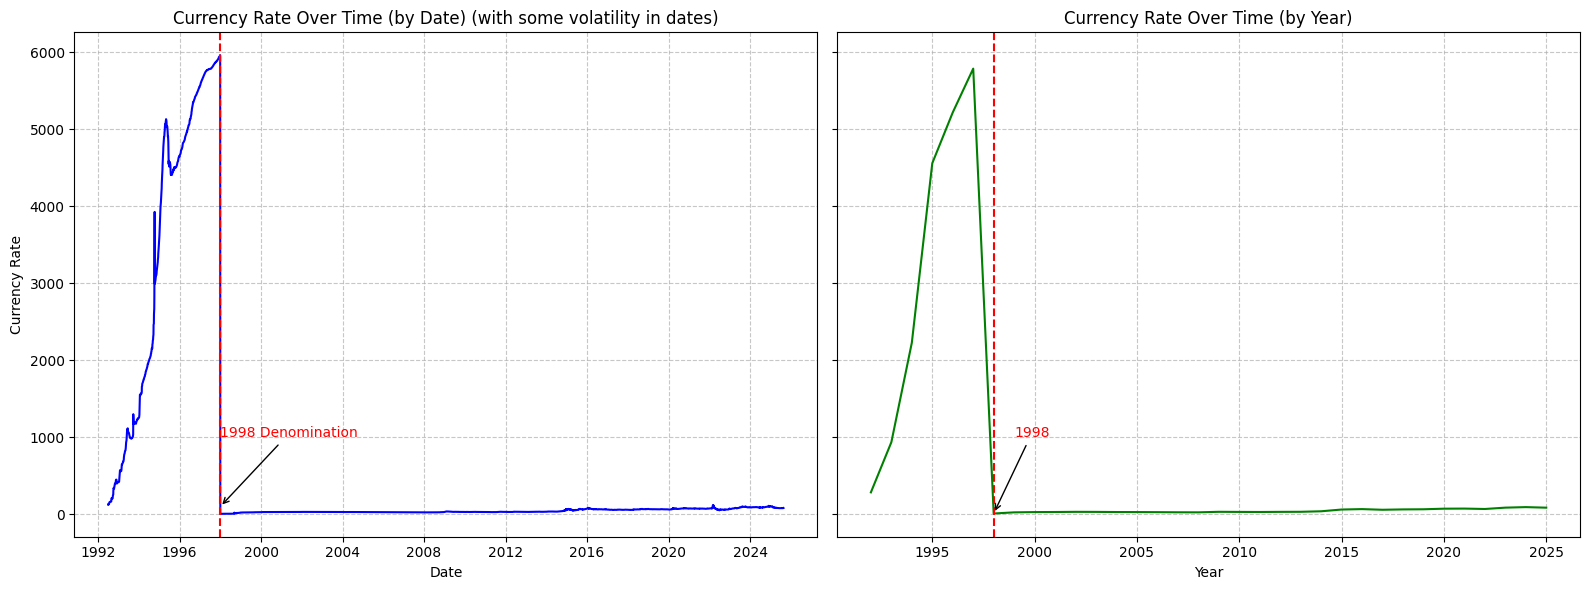

In [337]:
data['year'] = pd.to_datetime(data['date']).dt.year
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot 1: Full date-level currency rate
sns.lineplot(data=data, x="date", y="currency_rate", ax=axs[0], color="blue")
axs[0].set_title("Currency Rate Over Time (by Date) (with some volatility in dates)")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Currency Rate")
axs[0].grid(True, linestyle="--", alpha=0.7)


denom_date = pd.to_datetime("1998-01-01")
axs[0].axvline(denom_date, color="red", linestyle="--", linewidth=1.5)
axs[0].annotate("1998 Denomination", 
                xy=(denom_date, 100), 
                xytext=(denom_date, 1000),
                arrowprops=dict(facecolor="red", arrowstyle="->"),
                fontsize=10, color="red")

# Plot 2: Year-level average currency rate
yearly = data.groupby('year', as_index=False)['currency_rate'].mean()
sns.lineplot(data=yearly, x="year", y="currency_rate", ax=axs[1], color="green")
axs[1].set_title("Currency Rate Over Time (by Year)")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("")
axs[1].grid(True, linestyle="--", alpha=0.7)

# 1998
axs[1].axvline(1998, color="red", linestyle="--", linewidth=1.5)
axs[1].annotate("1998", 
                xy=(1998, yearly[yearly["year"] == 1998]["currency_rate"].values[0]),
                xytext=(1999, 1000),
                arrowprops=dict(facecolor="red", arrowstyle="->"),
                fontsize=10, color="red")

plt.tight_layout()
plt.show()

In [338]:
data['currency_rate_change'] = data['currency_rate'].pct_change() * 100

# find the date with the largest absolute percentage change
significant_change = data.loc[data['currency_rate_change'].abs().idxmax()]
significant_change_date = significant_change['date']
significant_change_value = significant_change['currency_rate_change']

significant_change_date, significant_change_value

(Timestamp('1998-01-01 00:00:00'), -99.9)

This adjustment is clearly visible in the data, with a sharp drop in the exchange rate between December 30, 1997, and January 1, 1998.

In [339]:
data[(data["date"] >= "1997-12-25") & (data["date"] <= "1998-01-08")]

,currency_rate,date,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change
794,5955.000,1997-12-25,1997,12,2737.572021,15.86,15.058504,4.864650e+09,15.058504,0.084034
795,5955.000,1997-12-26,1997,12,2737.572021,15.86,15.058504,4.864650e+09,15.058504,0.000000
796,5958.000,1997-12-27,1997,12,2737.572021,15.86,15.058504,4.864650e+09,15.058504,0.050378
797,5960.000,1997-12-30,1997,12,2737.572021,15.86,15.058504,4.864650e+09,15.058504,0.033568
798,5.960,1998-01-01,1998,1,1834.861816,15.59,18.538967,2.761360e+09,18.538967,-99.900000
799,5.963,1998-01-06,1998,1,1834.861816,15.59,18.538967,2.761360e+09,18.538967,0.050336
800,5.969,1998-01-07,1998,1,1834.861816,15.59,18.538967,2.761360e+09,18.538967,0.100620


#### Structural Flags: Pre/Post Denomination and Early Data Disruption

To account for known breaks in the data and improve model performance, I create two new columns:

1. **`denomination`**  
   Labels each observation based on whether it occurred before or after the 1998 ruble denomination:
   - "pre" for dates on or before 1997-12-30 (old rubles)
   - "post" for dates after that (new rubles)  
   This helps the model handle the sharp numerical shift in exchange rate levels after the currency reform.

2. **`post_soviet_disruption`**  
   Flags whether the date falls in the 1992–1996 range — the early post-Soviet period.  
   This period showed unusually high numbers of missing working days (see bar chart above), reflecting poor data quality and unstable market conditions.  
   The column is binary:
   - 1 for years 1992–1996
   - 0 otherwise

These flags won’t “fix” the breaks in the data but will let downstream models adjust for structural changes more effectively.

In [340]:
# Add dummy column for post_soviet_disruption
data["sov_disrupt"] = np.where((data["year"] >= 1992) & (data["year"] <= 1996), 1, 0)
data.head()

,currency_rate,date,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,sov_disrupt
0,125.26,1992-07-01,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,NaN,1
1,134.80,1992-07-03,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,7.616158,1
2,130.50,1992-07-08,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-3.189911,1
3,130.30,1992-07-10,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-0.153257,1
4,130.20,1992-07-15,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-0.076746,1


In [341]:
# label data with pre and post denomination
data["denomination"] = np.where(data["date"] <= "1997-12-30", "pre", "post")

# normilize currency rate
data["RUB"] = np.where(data["denomination"] == "pre", data["currency_rate"]/1000, data["currency_rate"])
data[(data["date"] >= "1997-12-25") & (data["date"] <= "1998-01-08")]

,currency_rate,date,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,sov_disrupt,denomination,RUB
794,5955.000,1997-12-25,1997,12,2737.572021,15.86,15.058504,4.864650e+09,15.058504,0.084034,0,pre,5.955
795,5955.000,1997-12-26,1997,12,2737.572021,15.86,15.058504,4.864650e+09,15.058504,0.000000,0,pre,5.955
796,5958.000,1997-12-27,1997,12,2737.572021,15.86,15.058504,4.864650e+09,15.058504,0.050378,0,pre,5.958
797,5960.000,1997-12-30,1997,12,2737.572021,15.86,15.058504,4.864650e+09,15.058504,0.033568,0,pre,5.960
798,5.960,1998-01-01,1998,1,1834.861816,15.59,18.538967,2.761360e+09,18.538967,-99.900000,0,post,5.960
799,5.963,1998-01-06,1998,1,1834.861816,15.59,18.538967,2.761360e+09,18.538967,0.050336,0,post,5.963
800,5.969,1998-01-07,1998,1,1834.861816,15.59,18.538967,2.761360e+09,18.538967,0.100620,0,post,5.969


In [342]:
data = data.rename(columns={"currency_rate": "old_RUB"})
data.head()

,old_RUB,date,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,sov_disrupt,denomination,RUB
0,125.26,1992-07-01,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,NaN,1,pre,0.12526
1,134.80,1992-07-03,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,7.616158,1,pre,0.13480
2,130.50,1992-07-08,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-3.189911,1,pre,0.13050
3,130.30,1992-07-10,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-0.153257,1,pre,0.13030
4,130.20,1992-07-15,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-0.076746,1,pre,0.13020


After correcting and normalizing data plots looking better.

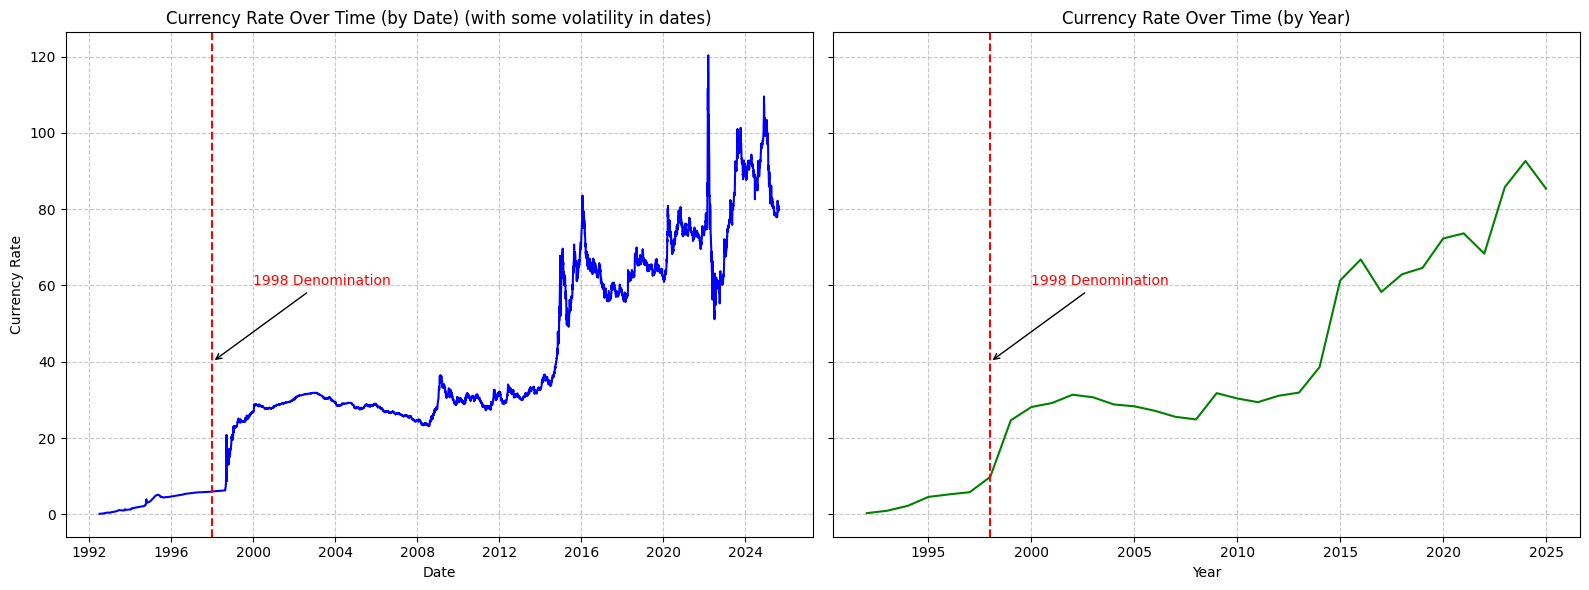

In [343]:
data['year'] = pd.to_datetime(data['date']).dt.year
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

denom_date = pd.to_datetime("1998-01-01")
arrow_y = 40
text_y = 60
text_x = pd.to_datetime("2000-01-01")

# Plot 1: Full date-level currency rate
sns.lineplot(data=data, x="date", y="RUB", ax=axs[0], color="blue")
axs[0].set_title("Currency Rate Over Time (by Date) (with some volatility in dates)")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Currency Rate")
axs[0].grid(True, linestyle="--", alpha=0.7)
axs[0].axvline(denom_date, color="red", linestyle="--", linewidth=1.5)
axs[0].annotate("1998 Denomination", 
                xy=(denom_date, arrow_y), 
                xytext=(text_x, text_y),
                arrowprops=dict(facecolor="red", arrowstyle="->"),
                fontsize=10, color="red")



# Plot 2: Year-level average currency rate
yearly = data.groupby('year', as_index=False)['RUB'].mean()
sns.lineplot(data=yearly, x="year", y="RUB", ax=axs[1], color="green")
axs[1].set_title("Currency Rate Over Time (by Year)")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("")
axs[1].grid(True, linestyle="--", alpha=0.7)
arrow_year = 1998
text_year = 2000
axs[1].axvline(arrow_year, color="red", linestyle="--", linewidth=1.5)
axs[1].annotate("1998 Denomination", 
                xy=(arrow_year, arrow_y), 
                xytext=(text_year, text_y),
                arrowprops=dict(facecolor="red", arrowstyle="->"),
                fontsize=10, color="red")

plt.tight_layout()
plt.show()

In [344]:
data_year = data.groupby("year").agg({"RUB": "mean"}).reset_index()
data_year.head()

,year,RUB
0,1992,0.284345
1,1993,0.936061
2,1994,2.227129
3,1995,4.558707
4,1996,5.217653


The chart shows the long-term trend of the ruble over the years. After its denomination in 1998, the ruble gradually depreciated, with periods of relative stability followed by renewed declines. Overall, the currency has shown a clear tendency to weaken over time, reflecting broader economic and structural challenges.


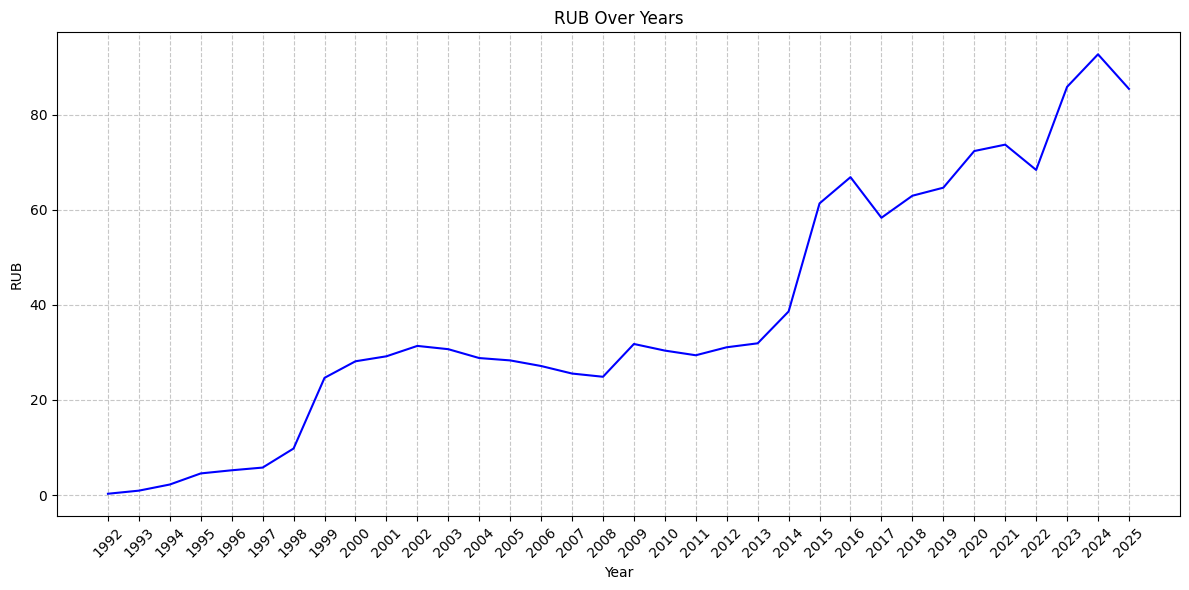

In [345]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_year, x="year", y="RUB", color="blue")

plt.xlabel("Year")
plt.ylabel("RUB")
plt.title("RUB Over Years")
plt.xticks(ticks=data_year["year"], labels=data_year["year"], rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### III. Key Events Shaping the Ruble

Now, to better understand the main drivers of ruble fluctuations, I highlight several major economic and geopolitical shocks on the timeline.
These events represent turning points where external crises or domestic policies significantly impacted the ruble’s trajectory:
* 1998 Default – August 17, 1998
* 2008 Global Financial Crisis – September 15, 2008
* 2014 Crimea – March 1, 2014
* 2020 COVID-19 Pandemic – March 11, 2020
* 2022 Russian Invasion of Ukraine – February 24, 2022

The following chart overlays these shocks on the ruble’s historical path to illustrate how closely currency movements align with key crises.

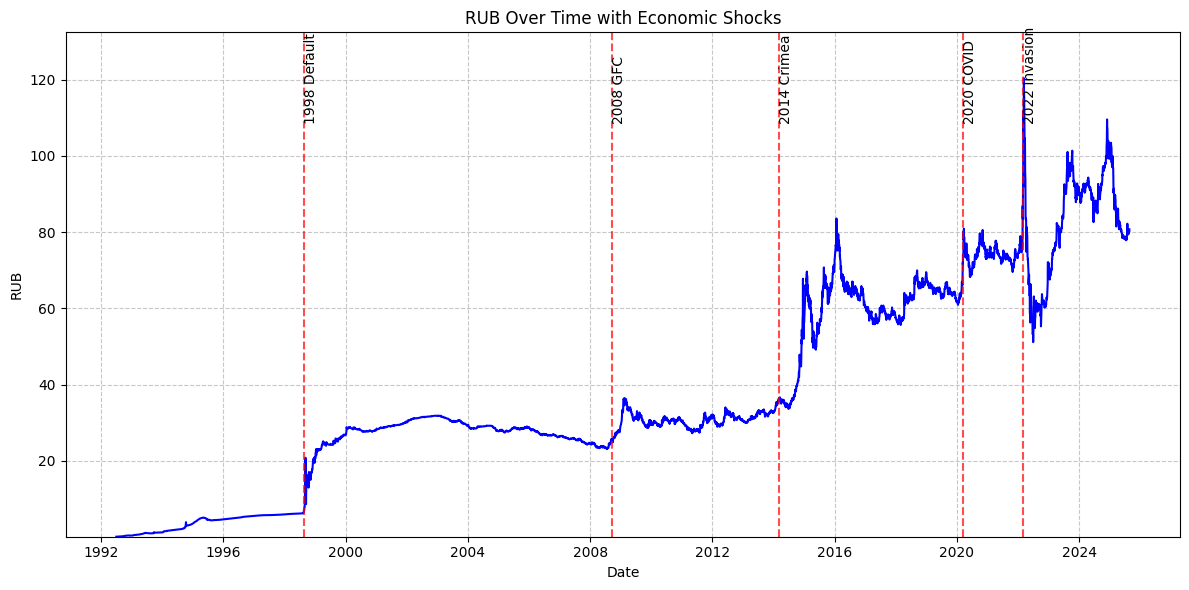

In [346]:
shocks = {
    "1998 Default": "1998-08-17",
    "2008 GFC": "2008-09-15",
    "2014 Crimea": "2014-03-01",
    "2020 COVID": "2020-03-11",
    "2022 Invasion": "2022-02-24"
}

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x="date", y="RUB", color="blue")

for label, date in shocks.items():
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.7)
    plt.text(pd.to_datetime(date), data['RUB'].max() * 0.9, label, rotation=90, verticalalignment='bottom')


plt.ylim(data['RUB'].min() * 0.9, data['RUB'].max() * 1.1)
plt.xlabel("Date")
plt.ylabel("RUB")
plt.title("RUB Over Time with Economic Shocks")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Each crisis left a lasting mark, pushing the currency to a new, weaker baseline rather than fully reverting. This pattern suggests that the ruble is highly sensitive to external pressures — both economic (global financial crises, oil prices) and geopolitical (sanctions, conflicts). Instead of smooth cyclical behavior, the ruble evolves through structural breaks that reset its long-term trajectory.

### IV. Time Series Plots

Converting Data to Monthly Frequency

As mentioned in the [01_Data_Input_and_Cleaning.ipynb](01_Data_Input_and_Cleaning.ipynb) notebook, I merged annual macroeconomic indicators with daily-level ruble data using forward-fill by year approach. While this allowed for merging across different frequencies, it doesn’t reflect any **intra-year macroeconomic changes**.

In this notebook, I now resample the data to monthly frequency by aggregating the daily RUB exchange rate, essentially applying **approach #4, Aggregate RUB to monthly, forward-fill macro"**. This adjustment provides a more stable and interpretable foundation for exploratory data analysis and time series modeling, while still retaining enough granularity to capture meaningful trends and shocks. 

What to keep in mind: 

- Loses some high-frequency detail
- May smooth out short-lived shocks or volatility

Final Setup:

* RUB exchange rate: Aggregated using monthly mean → smooths short-term volatility while preserving overall trends.
* Annual macro data (GDP, FDI, inflation): Forward-filled across each year → monthly mean reflects the correct annual value.
* Monthly macro data (oil prices): Forward-filled across each month → monthly mean recovers original monthly values.
* Dummy variables (e.g., post_denom, post_soviet_disruption): Categorical → last value of the month is retained, which preserves logical labels.


Yet, I will retain both versions (daily and monthly) throughout the project depending on context.

In [347]:
data.head()

,old_RUB,date,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,sov_disrupt,denomination,RUB
0,125.26,1992-07-01,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,NaN,1,pre,0.12526
1,134.80,1992-07-03,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,7.616158,1,pre,0.13480
2,130.50,1992-07-08,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-3.189911,1,pre,0.13050
3,130.30,1992-07-10,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-0.153257,1,pre,0.13030
4,130.20,1992-07-15,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-0.076746,1,pre,0.13020


In [348]:
data['date'] = pd.to_datetime(data['date'])

data_monthly = (
    data
    .set_index('date')
    .sort_index()  # ✅ ensure dates are in chronological order
    .resample('M')
    .agg(lambda x: x.mean() if pd.api.types.is_numeric_dtype(x) else x.iloc[-1])
)

# Save the monthly-aggregated data for further analysis
data_monthly.to_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_Ruble_Monthly_Data.csv", index=False)
data_monthly.tail()

,old_RUB,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,sov_disrupt,denomination,RUB
date,,,,,,,,,,,,
2025-04-30,83.243645,2025.0,4.0,14260.0,63.37,8.2,3.300000e+09,8.14,-0.213785,0.0,post,83.243645
2025-05-31,80.237650,2025.0,5.0,14260.0,64.32,8.2,3.300000e+09,8.14,-0.178412,0.0,post,80.237650
2025-06-30,78.677635,2025.0,6.0,14260.0,68.15,8.2,3.300000e+09,8.14,-0.004909,0.0,post,78.677635
2025-07-31,78.850139,2025.0,7.0,14260.0,73.43,8.2,3.300000e+09,8.14,0.101659,0.0,post,78.850139
2025-08-31,80.013656,2025.0,8.0,14260.0,67.83,8.2,3.300000e+09,8.14,0.034674,0.0,post,80.013656


#### Basic Time-Series Plots

a. Monthly Time-Series

In [349]:
# adding Macro Metrcis for plots

macro_vars = [
    ("GDP_per_capita", "GDP per Capita (USD)"),
    ("FD_investment", "Foreign Direct Investment (USD)"),
    ("Brent_price", "Brent Oil Price (USD/barrel)"),
    ("GDP_deflator", "GDP Deflator"),
    ("Inflation", "Inflation (%)"),
]

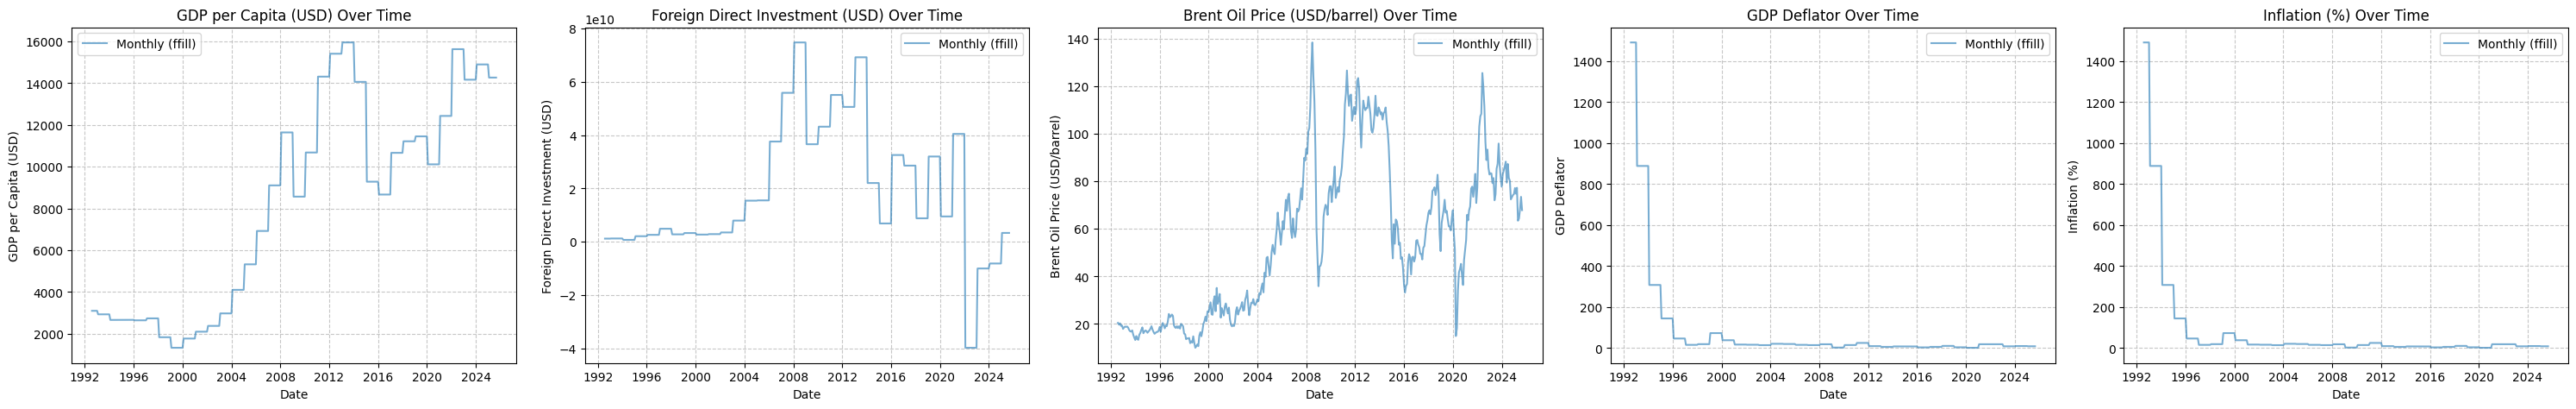

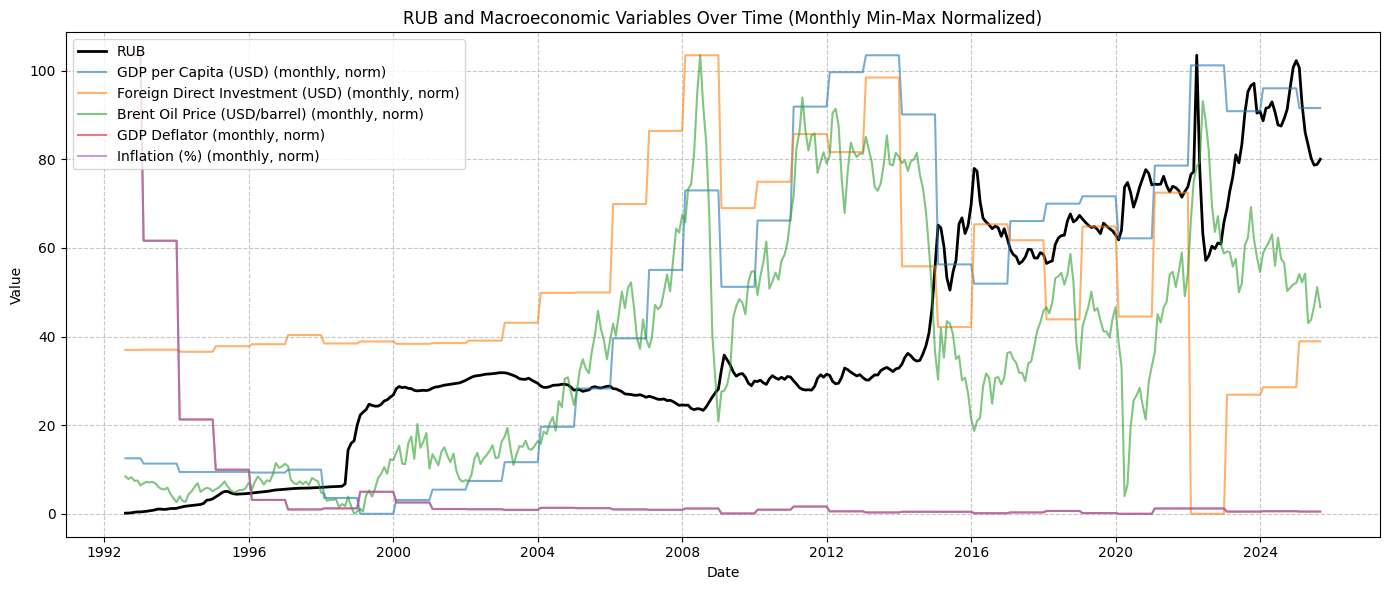

In [350]:
# index = DatetimeIndex
n_vars = len(macro_vars)
fig, axes = plt.subplots(1, n_vars, figsize=(6 * n_vars, 5), sharex=True)
if n_vars == 1:
    axes = [axes]
for ax, (var, label) in zip(axes, macro_vars):
    ax.plot(data_monthly.index, data_monthly[var], label="Monthly (ffill)", color="tab:blue", alpha=0.6)
    ax.set_xlabel("Date")
    ax.set_ylabel(label)
    ax.set_title(f"{label} Over Time")
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))
plt.plot(data_monthly.index, data_monthly["RUB"], label="RUB", color="black", linewidth=2)

for var, label in macro_vars:
    # normalize the variables to visually compare their trends on the same plot
    norm_monthly = (data_monthly[var] - data_monthly[var].min()) / (data_monthly[var].max() - data_monthly[var].min())
    plt.plot(data_monthly.index, norm_monthly * data_monthly["RUB"].max(), label=f"{label} (monthly, norm)", alpha=0.6)

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("RUB and Macroeconomic Variables Over Time (Monthly Min-Max Normalized)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

To compare variables on a single scale, I applied **min-max normalization** and overlaid them with the RUB exchange rate.  
This helps spot how the variables move together over time, where big shifts happen, and how the ruble reacts to major events.

**Key patterns:**
- RUB shocks often align with spikes in oil, FDI drops, and inflation surges.
- Major breaks: 1998 (default), 2008 (GFC), 2014 (Crimea), 2022 (sanctions).

The ruble’s historical sensitivity to oil prices is a well-documented phenomenon, largely due to Russia's role as a major oil-exporting economy.  
In particular, the RUB tends to strengthen when Brent oil prices rise and depreciate when oil prices fall — highlighting the currency’s strong link to global energy markets.

b. Yearly Time-Series

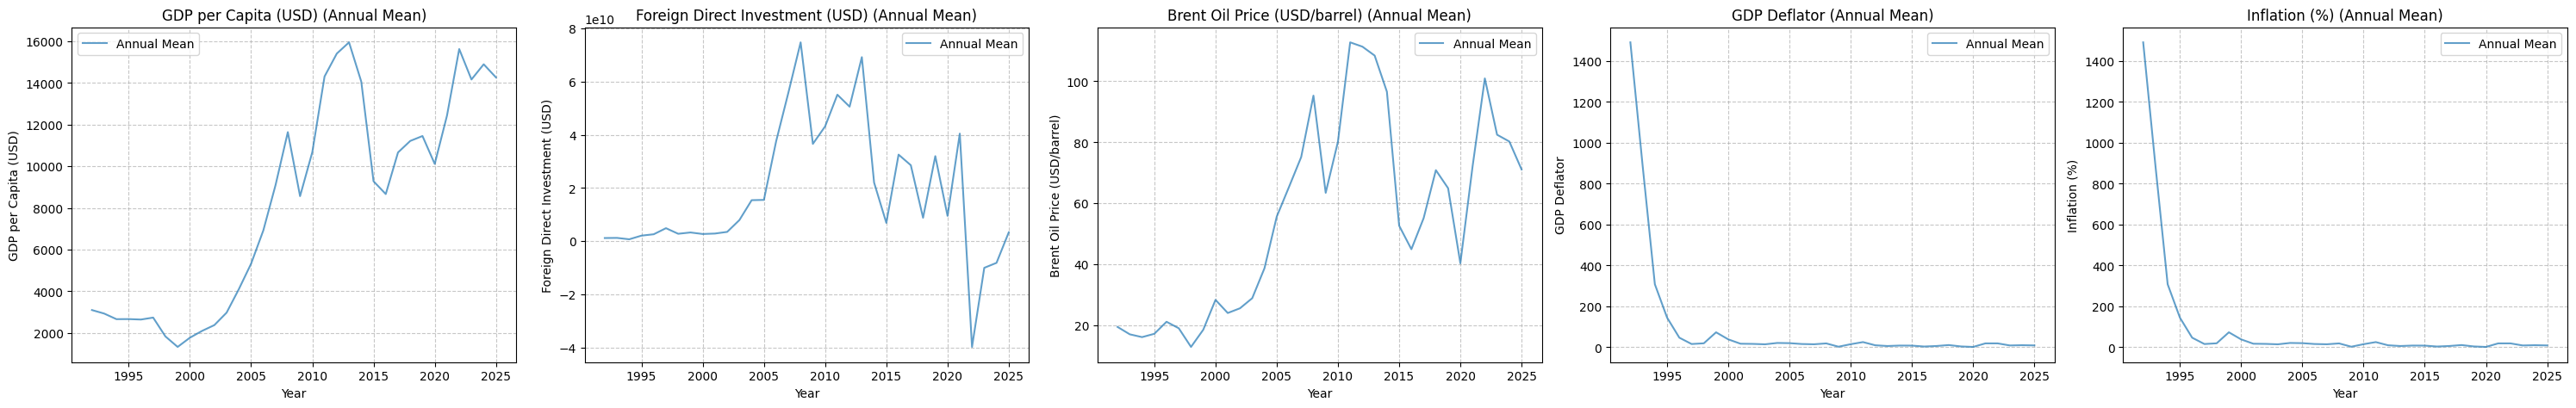

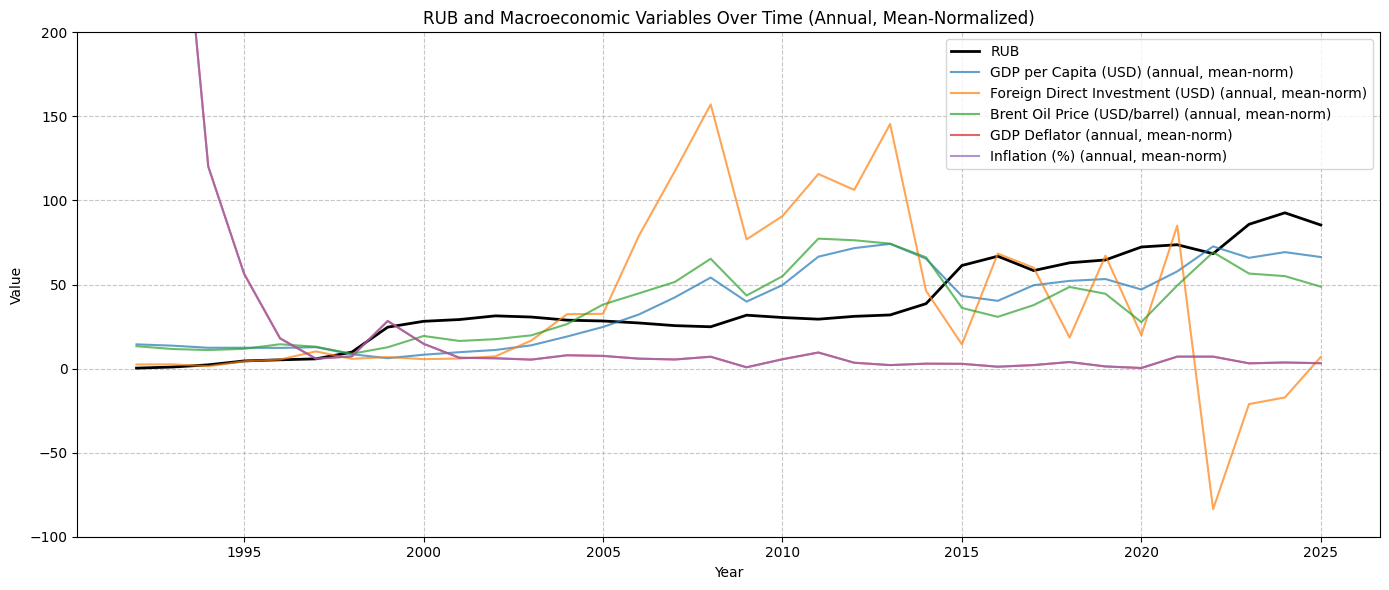

In [351]:
annual_data = data.groupby("year").agg({**{var: "mean" for var, _ in macro_vars}, "RUB": "mean"}).reset_index()

n_vars = len(macro_vars)
fig, axes = plt.subplots(1, n_vars, figsize=(6 * n_vars, 5), sharex=True)
if n_vars == 1:
    axes = [axes]
for ax, (var, label) in zip(axes, macro_vars):
    ax.plot(annual_data["year"], annual_data[var], label="Annual Mean", color="tab:blue", alpha=0.7)
    ax.set_xlabel("Year")
    ax.set_ylabel(label)
    ax.set_title(f"{label} (Annual Mean)")
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend()
plt.tight_layout()
plt.show()

# combined plot: RUB and selected macro variables for visual comparison (annual, mean-normalized)
plt.figure(figsize=(14, 6))
plt.plot(annual_data["year"], annual_data["RUB"], label="RUB", color="black", linewidth=2)

for var, label in macro_vars:
    # Normalize by mean for visual comparison (annual only)
    norm_annual = annual_data[var] / annual_data[var].mean()
    plt.plot(annual_data["year"], norm_annual * annual_data["RUB"].mean(), label=f"{label} (annual, mean-norm)", alpha=0.7)

plt.xlabel("Year")
plt.ylabel("Value")
plt.title("RUB and Macroeconomic Variables Over Time (Annual, Mean-Normalized)")
plt.ylim(-100, 200)  # only restrict y limits for the main combined plot
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

To complement the monthly analysis, I aggregated all variables to yearly frequency using the annual mean. This reduces short-term noise and highlights long-term structural shifts and macroeconomic trends.
Notably, **GDP per capita and Oil prices show a strong positive correlation**, especially between 2000 and 2014. As Brent oil prices rise, GDP per capita tends to increase as well — highlighting the Russian economy’s dependence on energy exports.

### VI. Correlation Analysis

To explore linear contemporaneous relationships, I compute a correlation matrix. The main goal of this exercise is to examine how the RUB co-moves with macroeconomic variables and major disruptions.

1. Correlation Heatmap 

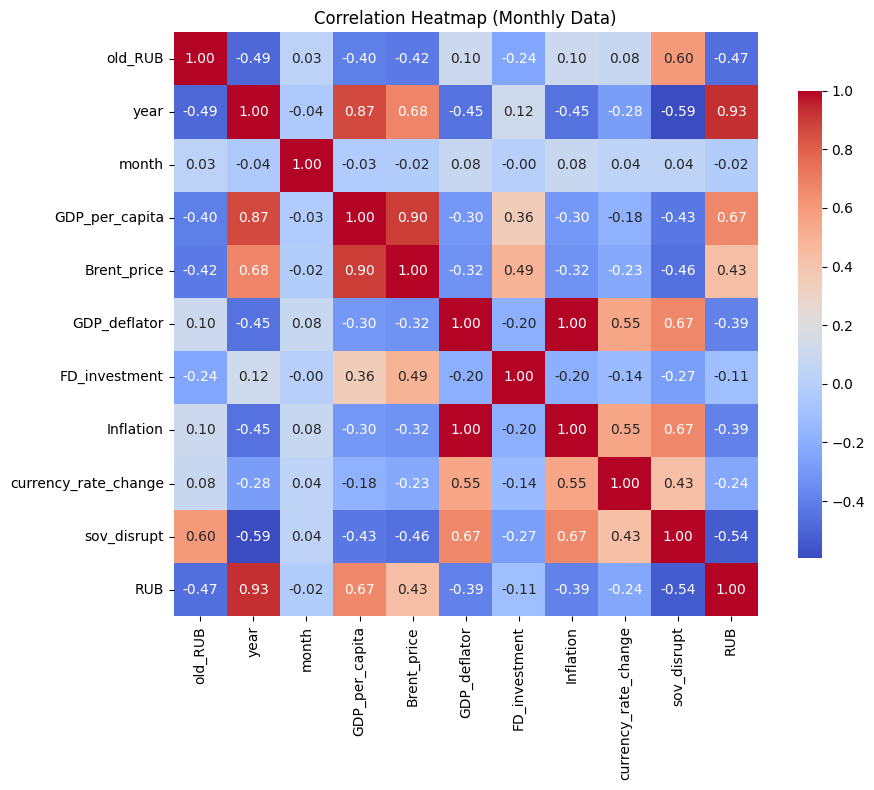

In [ ]:
corr = data_monthly.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap (Monthly Data)")
plt.tight_layout()
plt.show()

2. Correlation Heatmap wit shocks

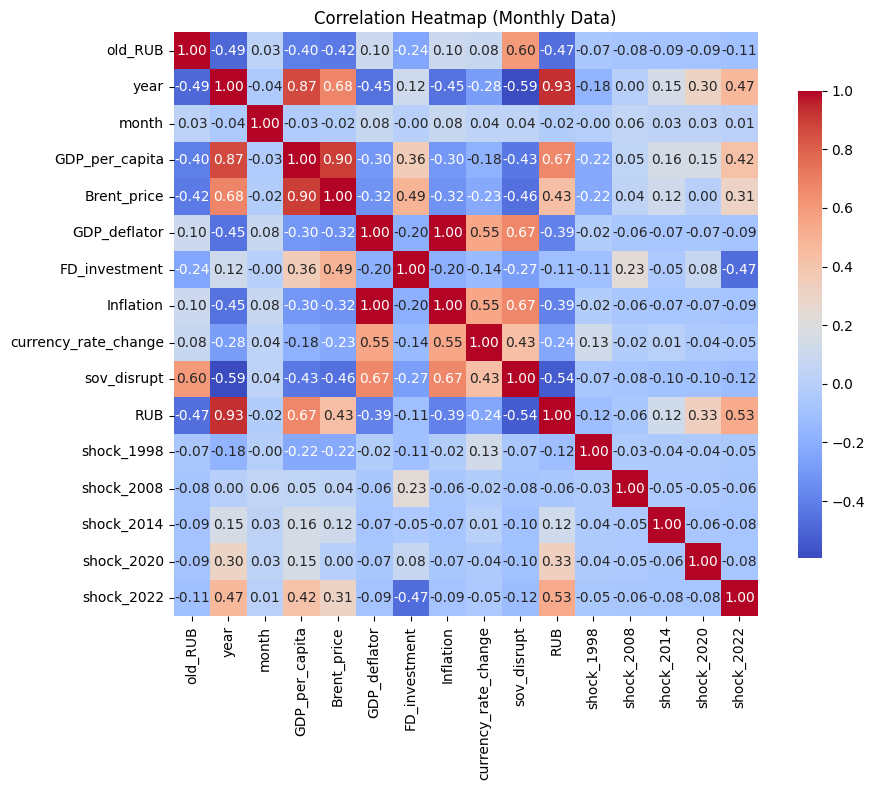

In [355]:
data_monthly["shock_1998"] = ((data_monthly.index >= "1998-08-17") & (data_monthly.index <= "1999-06-30")).astype(int)
data_monthly["shock_2008"] = ((data_monthly.index >= "2008-09-15") & (data_monthly.index <= "2009-12-31")).astype(int)
data_monthly["shock_2014"] = ((data_monthly.index >= "2014-03-01") & (data_monthly.index <= "2015-12-31")).astype(int)
data_monthly["shock_2020"] = ((data_monthly.index >= "2020-03-11") & (data_monthly.index <= "2021-12-31")).astype(int)
data_monthly["shock_2022"] = ((data_monthly.index >= "2022-02-24") & (data_monthly.index <= "2024-12-31")).astype(int)

corr = data_monthly.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap (Monthly Data)")
plt.tight_layout()
plt.show()

Key Takeaways:

RUB is strongly time-driven

* High positive correlation with year (0.93) suggests RUB depreciation over time likely driven by long-term inflation or structural changes.

Some macro variables appear misleading

* `GDP_per_capita` (0.67) and `Brent_price` (0.43) show positive correlation with RUB (i.e., RUB weakens as GDP or oil rises). This is unintuitive and likely reflects confounding trends (e.g., inflation dominating signal), not real-time causal links.

Multicollinearity is a real concern

* Very strong correlation between `GDP_per_capita`, `Brent_price`, and year (all >0.85) means models using all three may suffer from instability.

→ Recommendation: Use PCA, remove one, or regularize in modeling (e.g., Ridge).

Shocks show low raw correlation with RUB

* Individual shock dummies (e.g., shock_2022, shock_1998) have weak correlations (e.g., 0.05–0.53).

→ Still useful for modeling structural breaks, but not linearly correlated in raw form.

`sov_disrupt` might be misleading

* Correlates negatively with RUB (–0.54), which appears to show the ruble was stronger during political disruption.

→ This is due to sov_disrupt being active only 1992–1996 and not relevant across the full timeline.

Predicting currency movements for a country as large and volatile as Russia is, frankly, a daunting task. The ruble doesn’t move based on one or two macro signals, it reacts to a dense web of exogenous shocks, endogenous trends, and latent structural dynamics, many of which are hard to quantify and even harder to time. I’m not aiming for flawless forecasting here, but I am trying to build a model that’s as honest and close to the real data-generating process as possible.

**What I’m Doing Next**

***Not chasing surface-level correlations***

I’m intentionally moving away from relying on raw pairwise correlations. In real-world time series, effects aren’t always immediate, they’re often lagged, nonlinear, or only emerge during shocks. Simple correlations can mislead if taken at face value.

***Capturing structural shifts with interaction terms***

I plan to introduce interaction variables like GDP × shock_2022 to uncover how relationships behave differently during crises. This helps me model short-term structural changes, not just long-run averages.

***Leaning into more robust modeling frameworks***

To tackle multicollinearity and dynamic effects, I’ll experiment with:

* Regularization (Lasso, Ridge)
* Lagged variables
* Possibly regime-switching models if I find evidence of shifts

### VII. Seasonal Decomposition 

With Classical decomposition:

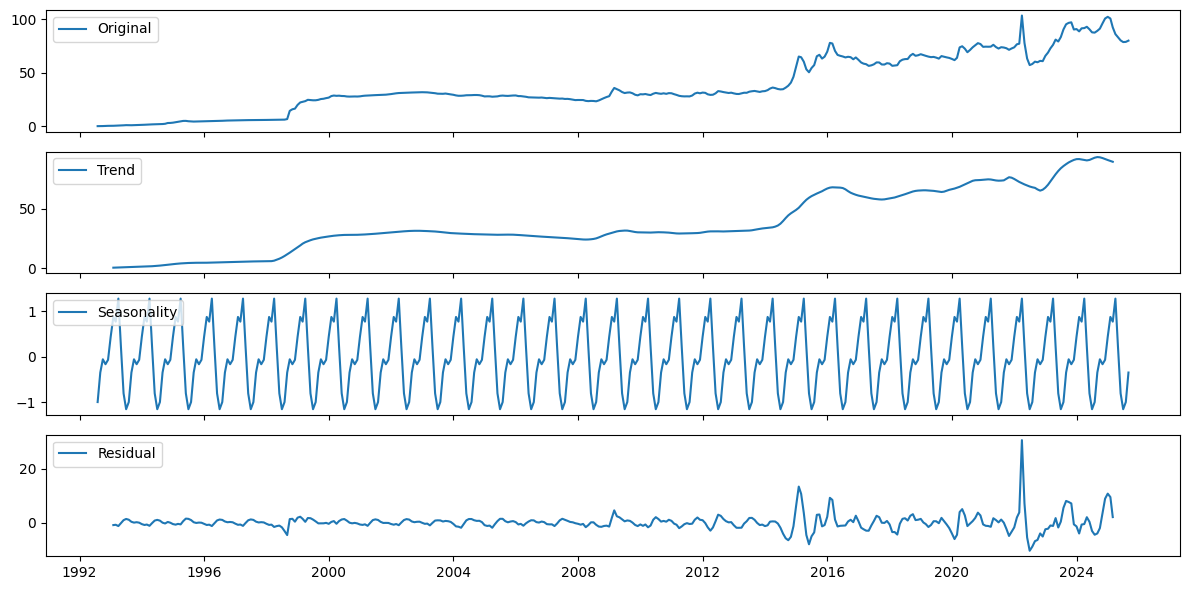

In [ ]:
data_decomp = data_monthly.copy()
data_decomp = data_decomp.sort_index()
rub_series = data_decomp["RUB"]
decomposition = seasonal_decompose(rub_series, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)
axes[0].plot(rub_series, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(decomposition.trend, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(decomposition.seasonal, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(decomposition.resid, label='Residual')
axes[3].legend(loc='upper left')

plt.tight_layout()
plt.show()

With Seasonal-Trend decomposition using LOESS (STL) decomposition:

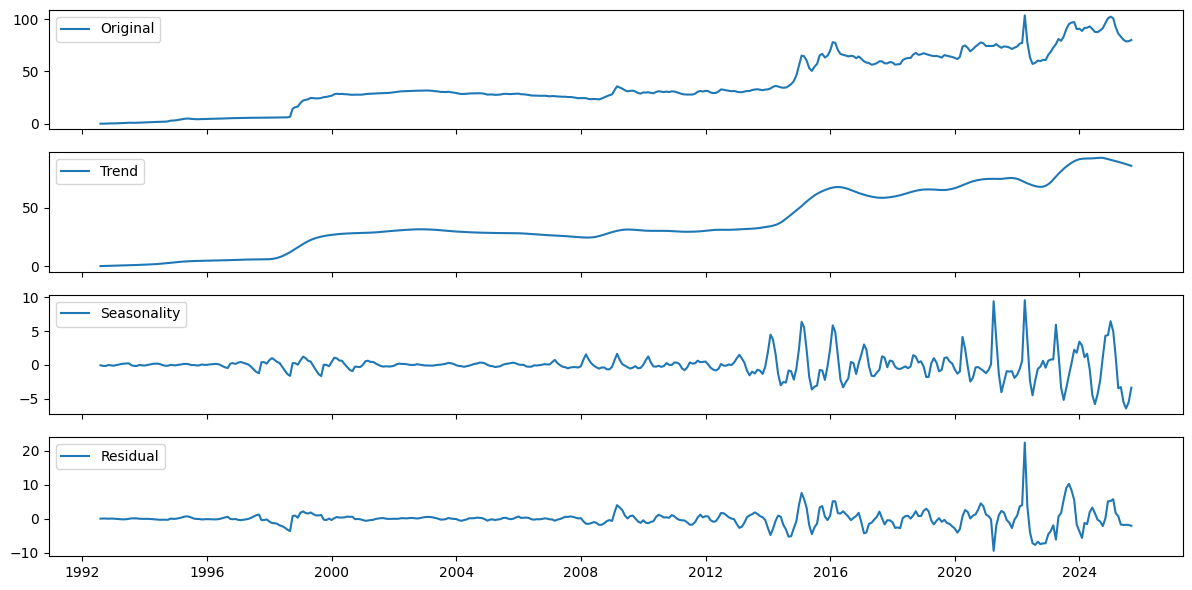

In [ ]:
stl = STL(rub_series, period=12) 
result = stl.fit()
trend = result.trend
seasonal = result.seasonal
resid = result.resid

fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)
axes[0].plot(rub_series, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(trend, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(seasonal, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(resid, label='Residual')
axes[3].legend(loc='upper left')

plt.tight_layout()
plt.show()

STL offers superior performance for long-term, real-world financial data like exchange rates, especially when structural breaks or non-stationary behavior is present.

In [366]:
result = adfuller(data["RUB"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -1.2938804992779496
p-value: 0.6319673214926405
Critical Values: {'1%': -3.431206441353405, '5%': -2.8619184832442954, '10%': -2.56697146213229}


Since the ADF statistic is higher than all critical values, and the p-value is well above 0.05, we fail to reject the null hypothesis of a unit root. This indicates that the RUB time series is non-stationary.
To proceed with time series modeling, let's apply first-order differencing to induce stationarity.

In [367]:
data.loc[:, 'RUB_diff1'] = data['RUB'].diff()  # First difference (today - yesterday)
data.loc[:, 'RUB_diff12'] = data['RUB'].diff(12)  # Seasonal difference (this month - same month last year)

rub_diff1 = data['RUB_diff1'].dropna()
result = adfuller(rub_diff1)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -15.066128585548803
p-value: 8.860286973543265e-28


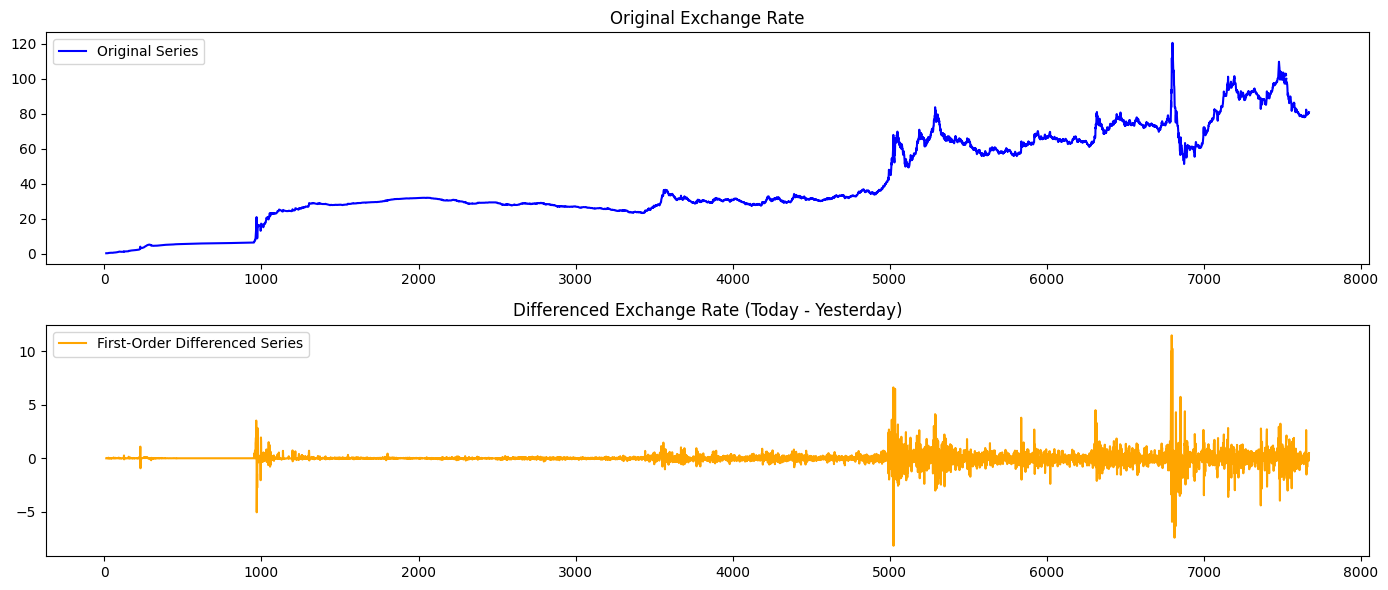

In [368]:
# First-order differencing
data['RUB_diff1'] = data['RUB'].diff()
data = data.dropna()

# Plotting both
plt.figure(figsize=(14, 6))

# Original
plt.subplot(2, 1, 1)
plt.plot(data['RUB'], label='Original Series', color='blue')
plt.title('Original Exchange Rate')
plt.legend()

# Differenced
plt.subplot(2, 1, 2)
plt.plot(data['RUB_diff1'], label='First-Order Differenced Series', color='orange')
plt.title('Differenced Exchange Rate (Today - Yesterday)')
plt.legend()

plt.tight_layout()
plt.show()

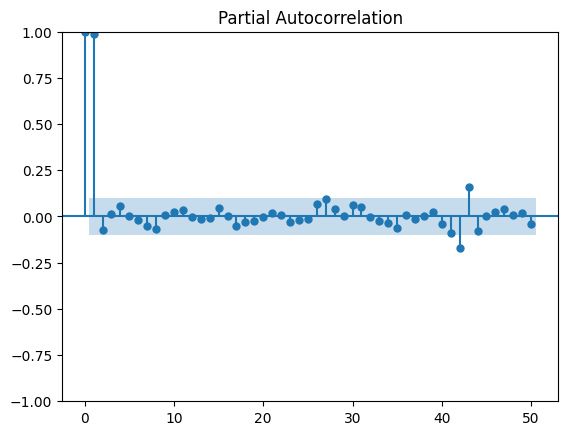

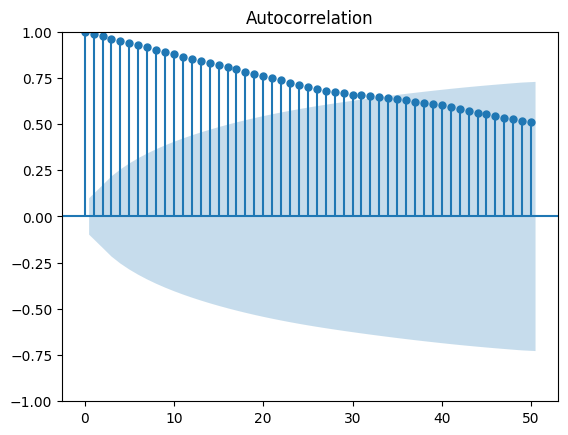

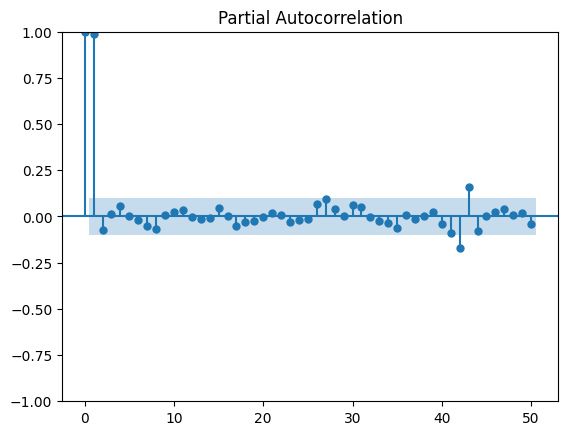

In [369]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data_monthly['RUB'].dropna(), lags=50)
plot_pacf(data_monthly['RUB'].dropna(), lags=50)

### VIII. Lag Feature Preview

In [ ]:
#data_monthly['Brent_lag1'] = data_monthly['Brent_price'].shift(1)
#data_monthly['GDP_lag3'] = data_monthly['GDP_per_capita'].shift(3)

### Summary:

This notebook ...

Next steps:
- 
- 
- Run event studies and synthetic control methods to assess causal shock